In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from model import Net

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((.5,), (.5,))
])

BATCH_SIZE=1

testset = torchvision.datasets.KMNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [3]:
lmbda = 100.
net = Net(reg_param=lmbda)
net.load(name=f'kmnist_lambda{lmbda}')
net.eval()
print(net)

re_param: 100.0
Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=10, bias=True)
  (act): Softmax(dim=-1)
)


In [4]:
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    #perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

def test_attack( model, test_loader, epsilon ):

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(model.device), target.to(model.device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = net.loss_fn(output, target, data, regularize_grads=False)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                data_ex = data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex, data_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                data_ex = data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex, data_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

def test(net, dataloader):
    correct = 0.
    total = 0.
    loss = 0.
    with torch.no_grad():
        for data in dataloader:
            images, labels = data[0].to(net.device), data[1].to(net.device)
            outputs = net(images)
            run_loss = net.loss_fn(outputs, labels, images, regularize_grads=False).item()
            loss += run_loss
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            run_acc = (predicted == labels).sum().item()
            correct += run_acc

    return correct / total * 100, loss / len(dataloader)

In [5]:
accuracies = []
examples = []

epsilons = [0.1, 0.2, 0.5, 0.9]

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test_attack(net, testloader, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0.1	Test Accuracy = 8217 / 10000 = 0.8217
Epsilon: 0.2	Test Accuracy = 5250 / 10000 = 0.525
Epsilon: 0.5	Test Accuracy = 333 / 10000 = 0.0333
Epsilon: 0.9	Test Accuracy = 173 / 10000 = 0.0173


In [6]:
from skimage.io import imsave, imread
for i, eps in enumerate(epsilons):
    for j in range(5):
        orig, adv, ex, clean = examples[i][j]
        img = ex
        img -= np.min(img)
        img /= np.max(img)
        imsave(f'kmnist_examples/{eps}/{j+1}/adversarial.png', (img * 255).astype(np.uint8))
        img = clean
        img -= np.min(img)
        img /= np.max(img)
        imsave(f'kmnist_examples/{eps}/{j+1}/clean.png', (img * 255).astype(np.uint8))
        img = (ex - clean)
        img -= np.min(img)
        img /= np.max(img)
        imsave(f'kmnist_examples/{eps}/{j+1}/diff.png', (img * 255).astype(np.uint8))

Text(0.5, 1.0, 'diff')

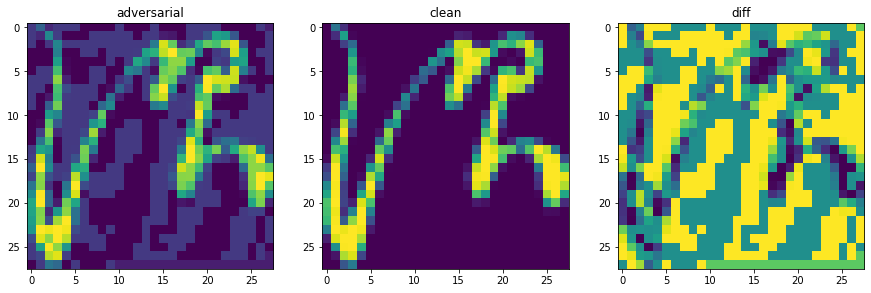

In [11]:
#acc, ex = test(net, testloader)
fig = plt.figure(figsize=(15, 7))

eps_ind, ex_ind = 1, 1
dataset = 'kmnist_examples'
ex = imread(f'{dataset}/{epsilons[eps_ind]}/{ex_ind}/adversarial.png')
ex = ex / 255.
clean = imread(f'{dataset}/{epsilons[eps_ind]}/{ex_ind}/clean.png')
clean = clean / 255.
diff = imread(f'{dataset}/{epsilons[eps_ind]}/{ex_ind}/diff.png')
diff = diff / 255.

ax = fig.add_subplot(1, 3, 1)
plt.imshow(ex)
ax.set_title('adversarial')

ax = fig.add_subplot(1, 3, 2)
plt.imshow(clean)
ax.set_title('clean')

ax = fig.add_subplot(1, 3, 3)
plt.imshow(diff)
ax.set_title('diff')